# Week 2: decoding analyses

This week's tutorial is about how to implement decoding analyses in Python. We'll be looking at the implementation of concepts like K-fold cross-validation, feature-selection/extraction, model fitting/prediction, permutation testing, and feature visualization. To do so, we'll use the [`scikit-learn`](http://scikit-learn.org) machine learning package in Python (the de-facto and most-used ML package in Python). Additionally, we'll use some functionality from the [`skbold`](http://skbold.readthedocs.io/en/latest/) to simplify some of steps in implementing decoding pipelines. In this tutorial, we'll use the PIOP-dataset (**P**opulation **I**maging **O**f **P**sychology), a large-scale (>240 subjects) multimodal MRI-dataset, including structural (gray-matter [VBM](https://en.wikipedia.org/wiki/Voxel-based_morphometry) and white-matter [TBSS](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/TBSS)), resting-state (incl. [dual regression](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/DualRegression) data), and task-based functional data. Along with this set of MRI-scans, the PIOP-study also acquired a set of behavioral (psychometric) variables from various questionnaires and behavioral task (outside the scanner) of the same participants who were scanned. As such, this makes it an excellent data-set for decoding analyses in which you can use neural patterns (from any MRI modality; `X`) to predict a behavioral variable (`y`). This is, by the way, also one of the data-sets that you can use for your final project (more info on Blackboard/week_4).

For this tutorial, we'll focus on a specific decoding analysis in which *we try to predict intelligence (y) from brain patterns (X) associated with working memory processing* (based on the same data as you practiced with in the tutorial of week 1). Throughout the tutorial, we'll discuss all the steps necessary to answer this research question. (Mini-ToThink: is this a within- or between-subject analysis?)

In terms of skills, after this tutorial you are be able to:

* Load and appropriately transform dependent variables (`y`) corresponding to your patterns (`X`);
* Apply basic [preprocessing](http://scikit-learn.org/stable/modules/preprocessing.html) to your patterns;
* Implement [feature-selection](http://scikit-learn.org/stable/modules/feature_selection.html#feature-selection) and extraction processes;
* Build fully cross-validated [pipelines](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline) using scikit-learn;
* Run appropriate statistics (including permutation tests) on your model performance scores;
* Visualize features by "back-projecting" (inverted) features to brain-space;

In combination with the knowledge/skills you acquired from last week's tutorial, you'll be able to implement a complete decoding pipeline yourself at the end of this tutorial!

## 1. Data representation (yet again)
Before we'll start with the machine learning stuff, we have to load in our patterns again. Like last week, you are going to use a custom `Mvp` class for this again, which we'll extend throughout this tutorial. You may use your own class from last week (given that it contains correct implementations of the load, standardize and apply_mask methods), or use the one in the solutions-notebook from last week. In any case, copy the code for the Mvp-class below:

In [251]:
import numpy as np
import nibabel as nib

class Mvp():
    """ Custom class to load, organize, and process multivoxel MRI patterns. """
    
    def __init__(self, paths):
        
        self.paths = paths
        
    def load(self, voxel_dims=(91, 109, 91)):
        
        X = np.zeros((len(self.paths), np.prod(voxel_dims)))

        # Start your loop here!
        for i, path in enumerate(self.paths):
    
            X[i, :] = nib.load(path).get_data().ravel()
        
        self.X = X
    
    def standardize(self):
        self.X = (self.X - self.X.mean(axis=0)) / self.X.std(axis=0)
        self.X[np.isnan(self.X)] = 0
        
    def apply_mask(self, path_to_mask, threshold):
        
        mask = nib.load(path_to_mask).get_data()
        mask_bool = mask > threshold
        self.X = self.X[:, mask_bool.ravel()]

Now, given our research question, we're going to use the (between-subject!\*) patterns of the working-memory task again. More specifically, we are going to use the patterns from the "active-passive" contrast of each subject (just like last week).

---------------
\* It's a between-subject analysis because intelligence is a factor that varies at the subject level!

What we'd like to do now is to load in the tstat3 patterns from all subjects who completed the working-memory task in the scanner. We put this dataset in the `/home/Public/FirstLevel_piop` folder. This folder (and all its subdirectories) is accessible (read-only, so you cannot modify anything) for all NIPA-students. 

<div class='alert alert-warning'>
**ToDo**: Click on the "Files" icon on your desktop and navigate (just by clicking, not in the terminal) to this directory (note: you have to go up one directory relative to your `home` directory).<br><br>

Check out the structure. You should see a bunch of subdirectories with subject-names (e.g. pi0010, pi0204, pi0084). These directories contain the first-level data (.feat directories) from the different task-based MRI-runs and some separate nifti-files (we'll get to these later). As you can see, we already estimated the (between-subject) patterns for you (which can be found in the .feat directories)! Go to a random subject's directory and click on the `*piopwm.feat` directory (note that not *all* subjects have this directory, because some subjects did not complete this run in the scanner due to technical issues or time issues). Check out the `design.png` file and the `reg_standard` directory (which files are in there? Do you understand what each file represents?). 
</div>

As you can see, the data is structured in an hierarchical way:

`/home/Public/FirstLevel_piop/{subject-no}/{task}.feat/reg_standard/{tstat-files}.nii.gz`

Given this structure, it's easy to `glob` a set of tstat-files for a specific task across all subjects. 

<div class='alert alert-warning'>
**ToDo**: use glob to find all the paths to the tstat3-files of the piopwm task. (Hint 1, you will need *two* wildcards in your search-string; Hint 2, you should find 217 paths in total)
</div>

In [252]:
# Implement the todo here (insert the right search-query in glob()):
from glob import glob
paths = glob('/home/lukas/between_data/pi*/*piopwm*/reg_standard/tstat3.nii.gz')
#paths = glob('/media/lukas/piop/PIOP/FirstLevel_piop/pi*/*piopwm*/reg_standard/tstat3.nii.gz')
print(len(paths))

29


Let's sort the paths, such that the paths are sorted by subject-number (pi0010 to pi0248). Also, let's not use *all* data (all subjects) at once, because that's actually quite memory-intensive and we don't want the TUX-server to crash. Therefore, we'll select only every third path (i.e. path 1, 4, 7, 10, etc.). 

In [253]:
paths = sorted(paths)
print("Number of paths was: %i" % len(paths))
subset_paths = paths[1::3]
print("Number of paths is now: %i" % len(subset_paths))

Number of paths was: 29
Number of paths is now: 10


Alright, now we have 72 paths (sorted by subject-number) to the subjects' tstat3 files. Let's initialize the Mvp object and call the `load()` method! 

<div class='alert alert-info'>
**ToThink**: before you initialize the Mvp object and load the patterns, can you predict what shape the `X`-attribute of the Mvp-object will be? (Hint: images in MNI152 2mm space are of shape 91\*109\*91)
</div>

Alright, less thinking, more doing:

In [254]:
mvp = Mvp(paths=subset_paths)
mvp.load()

Let's check the shape of the `X`-attribute:

In [255]:
print("Shape of X is: %s" % (mvp.X.shape,))

Shape of X is: (10, 902629)


### A note about standardization
We briefly touched upon the issue of "standardization" last week, but the process of standardization is especially important in decoding analyses, so it warrants some extra explanation. 

As explained before, standardization refers to the process of converting numbers in a vector to the (signed) number of standard deviations it deviates from the mean of the vector. Formally, for a vector `x` with mean $\bar{x}$ and standard deviation $s_{x}$ and length `N`, the standardized value of element $x_{i}$ is:

\begin{align}
x_{i} = \frac{x_{i} - \bar{x}}{s_{x}}
\end{align}

Practically, standardization in machine learning is applied to each column (i.e. feature), ensuring that each feature (in decoding: voxel) is on the same scale. In other words, standardization ensures that each feature has a mean of 0 and a standard deviation of 1.

"But *why* do you have to standardize your features?", you might reasonably ask. Well, that has to do with the way many ML models calculate their parameters (i.e. $\beta$; this process is called 'gradient descent'). For most models, this process may fail to converge and thus is unable to calculate the model's parameters is not all features are on the same scale. 

Anyway, just remember that *before you do any model fitting* your features should be standardized\*. Fortunately, you already implemented this yourself last week as a method in your mvp-class: the `standardize()` method! So, before we go on, let's just standardize our features:

-----------
\* There are also other ways to get your features on the same scale, like min-max scaling, but standardization is by far the most often used method.

In [256]:
mvp.standardize()

/home/lukas/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in divide


Cool, we got the (standardized) patterns (`X`) that we wanted. But as you might have noticed, we're still missing one crucial component for our decoding analysis: `y` (our to-be-decoded feature)! For our research question, we chose to focus on decoding intelligence, but how do we load and represent this in our pipeline? This is what the next section is about!

## 2. Adding a dependent variable (`y`)
While there is kind of a generic way to load in voxel patterns, there is usually not a single way to load in your dependent variable (y), because the exact factor that represents `y` dependent on your exact research question (and also depends how you have stored this data on disk). 

We'll focus on extracting a DV from a common tsv-file (like a csv-file, but not with comma- but tab-delimited values). Before we do that, just open the file and take a look at its structure. Just go to your desktop, double-click "Files", go up one directory (to `/home`) and go to `/home/Public/FirstLevel_piop`. Scroll aaaall the way down (past all the pi\* folders) and you'll find a file called `PIOP_BEHAV_NIPA.tsv` file. Double-click this, and press "Display". A "Text Import" window will pop up - select here "Tab" under the "Separated by" option. Then, click "OK". 

You'll see a spreadsheet with the subject-names in the first column and different variables in the columns. Basically, you can choose any variable in the columns as your to-be-decoded factor! For our example, we will pick the 'Raven' variable, which represents the subjects' (continuous) scores on the [Raven](https://en.wikipedia.org/wiki/Raven%27s_Progressive_Matrices) test, which aims to measure fluid intelligence. 

### 2.1. Loading behavioral data
To load in the tsv-file, we'll use `pandas`, a Python package for working with tabular data. It's main data structure is called the `DataFrame`, which is very similar to the dataframe-object in R. (Working with pandas is beyond the scope of this course, but you'll see it now and then throughout the course when we work with tsv-files.)

We'll walk you through how this is done:

In [257]:
import pandas as pd # This is how pandas usually is imported

#path_to_tsv = '/media/lukas/piop/PIOP/FirstLevel_piop/PIOP_BEHAV_NIPA.tsv'
path_to_tsv = '~/between_data/PIOP_BEHAV_NIPA.tsv'

# the read_csv function is the standard way to load in spreadsheet-like data
df = pd.read_csv(path_to_tsv, sep='\t', index_col=0)

# Let's see how this looks like
df.head()

,NEO_A,NEO_C,NEO_E,NEO_N,NEO_O,DOB_day,DOB_month,DOB_year,DOB_dmy,Gender,...,Opl_nu_rcht,Opl_tot.1,Opl_rcht_tot.1,Sexual_preference,Religie,Raven_raw,Raven_zscored,Raven_corrected_for_brainsize,wm_score,brainsize_t1
pi0001,47.0,39.0,35.0,40.0,42.0,2.0,10.0,1994.0,10/02/1994,2.0,...,6.0,2.0,6.0,1.0,1.0,21,-0.696968,-0.571876,NaN,1327159.0
pi0002,46.0,37.0,43.0,29.0,48.0,9.0,5.0,1992.0,05/09/1992,2.0,...,2.0,2.0,2.0,1.0,2.0,28,0.740011,NaN,NaN,NaN
pi0003,38.0,34.0,45.0,36.0,41.0,6.0,9.0,1990.0,09/06/1990,1.0,...,7.0,1.0,7.0,2.0,1.0,24,-0.081120,-0.198713,NaN,1504618.0
pi0004,47.0,46.0,40.0,22.0,43.0,27.0,10.0,1991.0,10/27/1991,2.0,...,12.0,2.0,9.0,1.0,1.0,23,-0.286403,-0.172240,NaN,1358498.0
pi0005,42.0,47.0,49.0,24.0,45.0,25.0,8.0,1992.0,08/25/1992,1.0,...,12.0,2.0,9.0,2.0,1.0,24,-0.081120,-0.217163,NaN,1521833.0


As you can see above, the DataFrame is simply a spreadsheet-like representation of the data, with the subjects represented as different rows and the different behavioral/demographic variables represented as columns. Now, we'd like to extract the `Raven_raw` columns, which represents the raw (summed) scores on the Raven-test for each subject. To do so, we can simply index the `df` variable with the string "Raven_raw" (just like indexing a dictionary). 

In [258]:
y = df['Raven_raw']
print("Length of y is: %i\n" % y.shape[0])
print("y looks like:\n\n%r" % y)

Length of y is: 248

y looks like:

pi0001    21
pi0002    28
pi0003    24
pi0004    23
pi0005    24
pi0006    31
pi0007    25
pi0008    25
pi0009    23
pi0010    18
pi0011    26
pi0012    23
pi0013    20
pi0014    28
pi0015    23
pi0016    25
pi0017    28
pi0018    14
pi0019    25
pi0020    19
pi0021    32
pi0022    21
pi0023    19
pi0024    26
pi0025    27
pi0026    24
pi0027    14
pi0028    30
pi0029    26
pi0030    24
          ..
pi0219    17
pi0220    14
pi0221    20
pi0222    25
pi0223    21
pi0224    28
pi0225    20
pi0226    25
pi0227    30
pi0228    24
pi0229    14
pi0230    19
pi0231    20
pi0232    20
pi0233    26
pi0234    26
pi0235    23
pi0236    16
pi0237    32
pi0238    28
pi0239    20
pi0240    23
pi0241    23
pi0242    24
pi0243    25
pi0244    25
pi0245    23
pi0246    32
pi0247    24
pi0248    23
Name: Raven_raw, dtype: int64


`y` is now a subset of the original dataframe (df) that only contains the Raven scores and a corresponding "index", which refers to the subject it belongs to. 

But we have a problem! 

`y` now contains 248 values (from 248 subjects), but our X attribute contains patterns from only 70 subjects (the subset selected earlier). For our analysis, the samples in our patterns (X) should match the entries in our dependent variable (y). How do we do this? Well, we need to extract which subjects were included in X and then use those subjects to "index" y. 

Below, we show you a way to do this.

In [259]:
# First we need to extract which subjects were actually included in X.
# We do this by extracting this info from the "subset_paths" from earlier
# using a list-comprehension (a fancy for loop)
subject_names = [path.split('/')[4] for path in subset_paths]

print(subject_names)

['pi0061', 'pi0064', 'pi0067', 'pi0070', 'pi0073', 'pi0076', 'pi0079', 'pi0083', 'pi0086', 'pi0089']


In [260]:
# Here we use the pandas dataframe "loc" method, which slices the DataFrame by their
# index names (and we subsequently transform the result to a numpy array)
y_new = np.array(y.loc[subject_names])

# And we can see now that the length of y is the same as the number of samples in X
print(mvp.X.shape)
print(y_new.shape)

(10, 902629)
(10,)


Great! Now we have a set of patterns (X) with a corresponding vector representing the to-be-decoded feature (y). There is, however, still one issue worth discussing. At this moment, `y` is a continuous measure (sum-score of performance on the Raven test). It follows then that our decoding analysis would use regression, but we will actually recode `y` such that it is categorical, as explained in the next section. 

### 2.2. Continuous vs. categorical DVs
In some scenario's you might want to recode your continuous dependent variable (y) into a categorical one. One reason is simply because fMRI patterns are incredibly noisy, and classification analyses are more robust than regression analyses. Note, though, that if you recode your continuous DV into a categorical one, your conclusions about your model also become weaker: regression models allow you to explain/model variance across a larger interval than classification models.

For example, would you be more impressed if told you I could model predict your IQ with an error of +/- 2 points (a continuous DV) or if I told you I could only predict whether your IQ is higher or lower than 100 (a categorical DV)? Given that your dependent variable is truly continuous, it's better to subject it to a regression analysis in terms of strength of your conclusion, but given the very noisy nature of fMRI data it may be advantageous to trade in some of this inferential strength for some extra SNR by recoding your DV into a categorical variable. 

This is probably also the reason that *classification* analyses are way more popular in the fMRI community than *regression* analyses. That's why we'll recode the Raven score into a categorical variable and continue with that for the rest of the tutorial. 

But how should we recode our DV? There are various ways to do this, but we'll use the median-split: any values above the median of `y` will be coded as 1 and any values below the median of `y` will be coded 0. Thus, our updated decoding goal is to predict whether someone has a high intelligence (`y = 1`) or low intelligence (`y = 0`).  

We'll show you how to implement this median-split transfor below ... No wait, you know what, by now you guys should be quite the Python experts: try it yourself!

<div class='alert alert-warning'>
**ToDo**: Transform mvp.y into categorical values {0, 1} using a median-split (you can use the numpy-function `median` to do this, i.e. np.median(some_array)). Hint: maybe you can use the [astype()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.astype.html) method of numpy arrays to convert boolean arrays to integer arrays?  
</div>

In [261]:
# transform mvp.y into zeros and ones using a median split


Okay, finally, we have everything we need for a decoding analysis: a sample-by-voxel array (X) representing the patterns and a vector with the corresponding to-be-decoded (categorical) variable (y). This is really all we need for a decoding analysis, we promise.

But the process of loading in a y-variable, making sure it corresponds to the same subjects contained in X, and transforming it using a median-split is kinda messy. For the following interim assignment, you have to incorporate this process in your Mvp class! 

<div class='alert alert-danger'>
**Assignment 1** (6 points): In this assigment, you will extend your Mvp class such that it is able to load in a y-variable from a tsv-file and index it such that it contains the data from the same subjects that were included in the X-attribute. So, first copy-paste the code for your class in the code-cell below. Then, do three things:<br><br>

1. *Within* your load() method, extract the subject-names from the `paths` attribute and store the results (which should be a list with subject-names, like this: ['pi0010', 'pi0011', 'pi0012', ..., etc.]) in a *new* attribute named 'subject_names'. You can use the list-comprehension defined earlier if you want to extract the subject-names. So, after calling the load() method, your mvp-object should also contain the attribute `subject_names` which represents which subjects the X-attribute is based upon.<br><br>

2. Then, add a new method named `load_y` that takes two arguments: a path (a string) to a tsv-file and a variable name (a string) referring to the column-name that should be extracted from the loaded tsv-file. Then, your method should load the tsv-file using pandas and extract the correct column. Also, it should filter the resulting values with the attribute `subject_names` such that you only extract y-values for the subjects that are actually included in X (using the `loc` method). The resulting (filtered) y-values should be stored *as a numpy array* in a *new* attribute called `y`. So, after calling `add_y`, mvp should contain the attribute `y`.<br><br>

So, calling the method would look something like this:<br> `my_mvp.load_y(path_to_tsv='/some/path/to/tsv-file.tsv', variable='Raven_raw')`<br>
Then, after calling `load_y`, the attribute `y` should be accessible (i.e. mvp.y should exist).<br><br>

3. Add another method, named `median_split_y` that takes no arguments (apart from *self*) and transforms the internal `y`-attribute into only 0 and 1 values using a median split.<br><br>

In the code-cell below your copy-pasted code for your Mvp class, we included some code to check whether your extension of Mvp is correct. If this cell runs without errors, you completed the assignment correctly.
</div>

In [262]:
class Mvp():
    """ Custom class to load, organize, and process multivoxel MRI patterns. """
    
    def __init__(self, paths):
        
        self.paths = paths
        
    def load(self, voxel_dims=(91, 109, 91)):

        self.subject_names = [path.split('/')[4] for path in self.paths]
        X = np.zeros((len(self.paths), np.prod(voxel_dims)))

        # Start your loop here!
        for i, path in enumerate(self.paths):
    
            X[i, :] = nib.load(path).get_data().ravel()
        
        self.X = X
    
    def standardize(self):
        self.X = (self.X - self.X.mean(axis=0)) / self.X.std(axis=0)
        
    def apply_mask(self, path_to_mask, threshold):
        
        mask = nib.load(path_to_mask).get_data()
        mask_bool = mask > threshold
        self.X = self.X[:, mask_bool.ravel()]
        
    def load_y(self, path, variable):
        
        df = pd.read_csv(path, sep='\t', index_col=0)
        y = df[variable]
        y = y.loc[self.subject_names]
        self.y = np.array(y)
        
    def median_split_y(self):
        
        self.y = (mvp.y > np.median(self.y)).astype(int)

In [263]:
# Run this cell to check your Mvp extension
# If there are no errors, you've done it correctly

mvp = Mvp(subset_paths)
mvp.load()

# Check if X-attribute exists
assert(hasattr(mvp, 'X'))

# Check if subject_names attribute exists
assert(hasattr(mvp, 'subject_names'))

# Check if the length of subject_names is the same as the rows in X
assert(len(mvp.subject_names) == mvp.X.shape[0])

print('You extended the load() method correctly!')

# Now, call the add_y method
mvp.load_y(path_to_tsv, 'Raven_raw')

# Check if y-attribute exists
assert(hasattr(mvp, 'y'))

# Check if y is indeed a numpy array
assert(isinstance(mvp.y, np.ndarray))

# Check if y is correctly filtered (i.e. only the subjects that are in subject_names)
assert(len(mvp.y) == len(mvp.subject_names) == mvp.X.shape[0])

print('You implemented the load_y() method correctly!')

# Call the median_split_y() method
mvp.median_split_y()

# Check if y is now binary {0, 1}
assert(all(np.unique(mvp.y) == [0, 1]))

# Check if nothing weird happened to the length of y
assert(len(mvp.y) == mvp.X.shape[0])

print('You implemented the median_split_y() method correctly!')

You extended the load() method correctly!
You implemented the load_y() method correctly!
You implemented the median_split_y() method correctly!


## What's next
Awesome, we now have everything we need (X and y) packaged neatly in an instance of your Mvp-class! As might have become clear by now, using classes to "package"/organize code can be quite efficient, especially if you're modifying variables a lot (like preprocessing of X). 

In the rest of the tutorial, you'll finally learn how to actually implement decoding pipelines. As discussed in the lecture, typical pipelines consist of the following elements:

* Data partitioning
* Feature selection/extraction
* Model fitting (on train-set)
* Model cross-validation (on test-set)
* Calculate model performance
* Statistical analyses of performance
* Optional: feature visualization

In the rest of the tutorial, we'll discuss these topics in a slightly different order. First, we'll discuss how you can fit and cross-validate scikit-learn models, and while we're at it, how to calculate model performance (here: accuracy). Subsequently, you'll learn how to embed these concepts in fully cross-validated K-fold data partitioning schemes. Then, we'll extend our pipelines with feature selection methods. Finally, we'll show you how to implement a permutation test and briefly show you how to visualize features. 

## 3. Model fitting & cross-validation
First, we'll show you how to use scikit-learn models. In fact, the most useful functionality of scikit-learn is probably that they made fitting and cross-validating models (or, in scikit-learn lingo: estimators) trivially easy. 

Note that in the upcoming example, we are going to fit the model on *all* our samples - this is something you'd never do of course (you always need to cross-validate it to a new, independent sample). 

Anyway, let's import a scikit-learn model: the (linear) support vector classifier ([SVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)), which is one of the most-often used models in fMRI pattern analyses. In scikit-learn, this model is part of the (suprising...) `svm` module:

In [264]:
# Scikit-learn is always imported as 'sklearn'
from sklearn.svm import SVC

Like most of scikit-learn's functionality, SVC is a *class*. So, let's initialize an SVC-object! One important argument that this object needs is the ["kernel"](http://scikit-learn.org/stable/auto_examples/svm/plot_svm_kernels.html) you want the model to have. Basically, the kernel determines how to treat/process your features: linearly, or non-linearly (such as the `kernel='rbf'` or `kernel='poly'` options). As discussed in the lecture, most often a linear kernel is the best option (as non-linear kernels seem to overfit very quicly). 

To initialize an SVC-object with a linear kernel, just do as follows:

In [265]:
# clf = CLassiFier
clf = SVC(kernel='linear')

Alright, so now we have initialized an SVC-object with a linear kernel. Now, you need to do two thing to get the prediction for each sample (i.e. whether they're predicted as 0 or 1): fit, using the method `fit(X, y)`, and predict the class (i.e. 0 or 1) for each class using the method `predict(X)`. Basically, in the `fit` method, the parameters of the model (i.e. $\beta$) are calculated. Then, in the `predict` method, the parameters are used to generate a prediction for each sample (i.e. 0 or 1). 

Let's first look at the `fit` method. As you can see, the `fit(X, y)` method with two parameters: X (a samples-by-features matrix) and y (a vector of length n-samples). Let's do that for our data stored in our mvp-object: 

In [266]:
clf.fit(mvp.X, mvp.y)
print('Fitted SVC ...')

Fitted SVC ...


After calling the fit() method, the clf-object contains an attribute `coef_` that represent the model's parameters ('coefficients' in scikit-learn lingo, i.e. $\beta$). Let's check that out:

In [267]:
coefs = clf.coef_
print("Shape of coefficients: %r" % (coefs.shape,))

Shape of coefficients: (1, 902629)


Ah, just like we expected: the `coef_` attribute is exactly the same size as the number of voxels in our X-matrix (i.e. 91\*109\*91). 

Anyway, usually, you don't do anything directly with the weights (perhaps only if you want to do anything with feature visualization): scikit-learn handles that for you. What you *do* want, is an actual prediction ($\hat{y}$) for our samples!

To get this, simply call the `predict(X)` method of the model, which returns the predictions as an array:

In [268]:
y_hat = clf.predict(mvp.X)
print("The predictions for my samples are: %r" % y_hat)

The predictions for my samples are: array([0, 0, 1, 1, 0, 1, 1, 0, 1, 0])


A logical next step is to assess how good the model was in predicting the class of the samples. A straightforward metric to summarize performance is *accuracy* which can be defined as: 

\begin{align}
accuracy = \frac{number\ of\ correct\ predictions}{number\ of\ predictions}
\end{align}

<div class='alert alert-warning'>
**ToDo**: Can you calculate the accuracy of the above model? Hint 1: you need to compare the true labels (i.e. mvp.y) with the predicted labels (i.e. y_hat). Hint 2: if you do arithmetic with boolean values (i.e. `True` and `False`), `True` is interpreted as 1 and `False` is interpreted as 0.
</div>

In [269]:
# Implement your to-do here!
accuracy = 

SyntaxError: invalid syntax (<ipython-input-269-c79b040c0188>, line 2)

If you've done the ToDo correctly above, you should have found out that the accuracy was 1.0 - a perfect score! "Awesome! Nature Neuroscience material!", you might think. But, as is almost always the case: if it's too good to be true, it probably *is* indeed too good to be true.

So, what is the issue here? Well, we didn't cross-validate the model! We fitted it on all the samples in the mvp-object and predicted the *same* samples, which leads to optimistic estimate of model performance. Such optimistic estimates in uncross-validated models are especially likely when there are many more features (here: voxels) than samples (here: subjects). In other words, we are probably *overfitting* the model here.

Thus, let's check what happens if we actually cross-validate the model. To do so, we need to partition the data into a train- and test-set. For this example, we'll use a simple hold-out scheme, in which we'll reserve half of the data for the test-set (we'll discuss more intricate cross-validation schemes such as K-fold in the next section).

Below, we index `X` and `y` such that the train-set will contain all odd-numbered samples and the test-set will contain all even-number samples:

In [270]:
X_train = mvp.X[1::2]
print("Shape X_train: %r" % (X_train.shape,))

y_train = mvp.y[1::2]
print("Shape y_train: %r" % (y_train.shape,))

X_test = mvp.X[0::2]
print("Shape X_test: %r" % (X_test.shape,))

y_test = mvp.y[0::2]
print("Shape y_test: %r" % (y_test.shape,))

Shape X_train: (5, 902629)
Shape y_train: (5,)
Shape X_test: (5, 902629)
Shape y_test: (5,)


<div class='alert alert-warning'>
**ToDo**: now it's up to you to actually implement the *cross-validated* equivalent of the fit/predict procedure we showed you before. So, fit your model on `X_train` and `y_train` and then predict `X_test`. Calculate the cross-validated accuracy by comparing the predictions with `y_test`. 
</div>

In [271]:
# Implement your ToDo here


Sweet! You actually performed your first proper decoding analysis in the ToDo above! There are however a couple of things we can do to improve the efficiency and results. One thing we can do is to use the data more efficiently in cross-validation. In the previous example, we split the data into two sets and fit the model on one (the train-set) and cross-validated to the other (the test-set). But as you've heard in the lecture, there is actually a way to "re-used" the data by using K-fold cross-validation, in which data is iteratively partitioned in train- and test-sets. This is explained in the next section.

## 3. Data partitioning: K-fold cross-validation
As discussed in the lecture, there are two principled ways of cross-validation: 

* Hold-out cross-validation;
* K-fold cross-validation;

In the previous section we implemented a form of hold-out cross-validation, which can be seen as a kind of "one-shot cross-validation". In fMRI data-sets, however, we usually have few samples (simply because MRI-data is expensive to acquire!), so K-fold cross-validation is more common than hold-out cross-validation in fMRI pattern analyses because it allows you to reuse the data.

Now, we can finally use some of scikit-learn's functionality. We are going to use the [StratifiedKFold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) object from scikit-learn's model_selection module. Click the highlighted link above and read through the manual to see how it works.

Importantly, if you're dealing with a classification analysis, always use *Stratified*KFold (instead of the regular [KFold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html)), because this version makes sure that each fold contains the same proportion of the different classes (here: 0 and 1). Anyway, enough talking. Let's initialize a StratifiedKFold object with 5 folds:

In [272]:
# scikit-learn is imported as 'sklearn'
from sklearn.model_selection import StratifiedKFold

# They call folds 'splits' in scikit-learn
skf = StratifiedKFold(n_splits=5)

Alright, we have a StratifiedKFold object now, but not yet any indices for our folds (i.e. indices to split X and y into different samples). To do that, we need to call the `split(X, y)` method:

In [273]:
folds = skf.split(mvp.X, mvp.y)

Now, we created the variable `folds` which is officially a [generator](https://wiki.python.org/moin/Generators) object, but just think of it as a type of list (with indices) which is specialized for looping over it. Each entry in `folds` is a tuple with two elements: an array with train-indices and an array with test-indices. Let's demonstrate that\*:

-------------
\* Note that you can only run the cell below once. After running it, the `folds` generator object is "exhausted", and you'll need to call `skf.split(mvp.X, mvp.y)` again in the above cell.

In [274]:
i = 1
for fold in folds:
    
    print("Processing fold %i" % i)
    # Here, we unpack fold (a tuple) to get the train- and test-indices
    train_idx = fold[0]
    test_idx = fold[1]
    
    print("Train-indices: %s" % train_idx)
    print("Test-indices: %s\n" % test_idx)
    
    i += 1
i = 0

Processing fold 1
Train-indices: [1 3 4 5 6 7 8 9]
Test-indices: [0 2]

Processing fold 2
Train-indices: [0 2 4 5 6 7 8 9]
Test-indices: [1 3]

Processing fold 3
Train-indices: [0 1 2 3 6 7 8 9]
Test-indices: [4 5]

Processing fold 4
Train-indices: [0 1 2 3 4 5 8 9]
Test-indices: [6 7]

Processing fold 5
Train-indices: [0 1 2 3 4 5 6 7]
Test-indices: [8 9]



As you can see, StratifiedKFold determined that for the first fold, sample 1 to 9 should be used for training and sample 0 and 2 (remember, Python uses 0-based indexing!) should be used for testing.

Now, we know how to access the train- and test-indices, but we haven't *actually* indexed our X and y (i.e. mvp.X and mvp.y) in the for-loop over folds. Nor have we actually fit the model on the train-set and cross-validated this to the test-set.

<div class='alert alert-warning'>
**ToDo**: in the code-cell below, complete the statements by indexing mvp.X and mvp.y to create four different objects in every fold: X_train, y_train, X_test, y_test. Also, we created a new classifier-object (clf) for you based on a different model: scikit-learn's `LogisticRegression` to show you that *every* model in scikit-learn works the same. Use this classifier to fit on the train-set and predict the test-set in every fold. Then, calculate the (cross-validated) accuracy in every fold. Keep track of the accuracies across folds, and after the loop over folds, calculate the average accuracy across folds.
</div>

In [275]:
from sklearn.linear_model import LogisticRegression

# clf now is a logistic regression model
clf = LogisticRegression()
# run split() again to generate folds
folds = skf.split(mvp.X, mvp.y)

accuracy = []

for fold in folds:
    
    # This is a slightly more concise way to unpack tuples
    train_idx, test_idx = fold
    
    # Complete these statements by indexing mvp.X and mvp.y with train_idx and test_idx
    X_train = 
    y_train = 
    
    X_test = 
    y_test = 
    
    # ToDo: call fit (on train) and predict (on test)
    
    # ToDo: calculate accuracy

# ToDo: calculate average accuracy


SyntaxError: invalid syntax (<ipython-input-275-94b4e270e3b4>, line 16)

Implementing K-fold cross-validation instead of hold-out cross-validation allowed us to make our analysis a little more efficient (by reusing samples). Another method that (usually) improves performance in decoding analyses is feature selection/extraction. 

## 4. Feature selection/extraction
As discussed before, a small sample/feature-ratio often results in overfitting (optimistic performance estimates on train-set). It follows then that reducing the amount of features often has a beneficial effect on cross-validated performance estimates.

Feature reduction can be achieved in two principled ways:

* feature extraction: transform your features into a set of lower-dimensional components;
* feature selection: select a subset of features

Examples of feature extraction are PCA (i.e. transform voxels to orthogonal components) and averaging features within brain regions from an atlas. Because feature extraction often does not use any information from the labels (`y`), this step does not need to be cross-validated (but you *can* cross-validate, e.g., PCA by estimating the components on the train-set only). 

Examples of feature selection are ROI-analysis (i.e. restricting your patterns to a specific ROI in the brain) and "univariate feature selection" (UFS). This latter method is an often-used data-driven method to select features based upon their univariate difference. 

Fortunately, scikit-learn has a bunch of feature selection/extraction objects for us to use. These objects ("transformers" in scikit-learn lingo) work similarly to estimators: they also have a `fit(X, y)` method, in which for example the univariate differences (in UFS) or PCA-components (in PCA-driven feature extraction) are computed. Then, instead of having a `predict(X)` method, transformers have a `tranform(X)` method.

Let's take a closer look at how UFS can be implemented using scikit-learn. Basically, it follows the following structure:

`transformer = Selector(score_func=ufs_function, other_args)`

Here, the `score_func` parameter takes a function that implements a univariate statistical test (like an [f-test](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html#sklearn.feature_selection.f_classif) or a [chi-square test](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html#sklearn.feature_selection.f_classif)). The `Selector` class determines how to select the subset of features based on the result of the `score_func`. 

For example, the [SelectKBest](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html#sklearn.feature_selection.SelectKBest) selector selects the best `K` features based on their scores from the statistical test. For example, the following transformer would select the best 100 features based on their F-score:

In [276]:
from sklearn.feature_selection import SelectKBest, f_classif

# f_classif is a scikit-learn specific implementation of the F-test
select100best = SelectKBest(score_func=f_classif, k=100)

Another example of a selector is `SelectFwe` which selects only features with statistics-values corresponding to p-values lower than a set alpha-level. For example, the following transformer would only select features with p-values from a chi-square test lower than 0.01: 

In [277]:
from sklearn.feature_selection import SelectFwe, chi2
selectfwe_transformer = SelectFwe(score_func=chi2, alpha=0.01)

<div class='alert alert-info'>
**ToThink**: The functions `f_classif` and `chi2` are functions to calculate statistics for when the the DV is categorical (i.e. in classification scenarios). Can you think of a function that does the same when your DV is continuous (i.e. in regression scenarios)? 
</div>

But how does this work in practice? We'll show you an (not cross-validated!) example using the select100best transformer initialized earlier:

In [284]:
# Fit the transformer ...
select100best.fit(mvp.X, mvp.y)

# ... which calculates the following attributes (.scores_ and .pvalues_)
# Let's check them out
scores, pvalues = select100best.scores_, select100best.pvalues_

# As you can see, each voxel gets its own score (in this case: an F-score)
print(scores.size)

902629


We can also visualize these scores in brain space (it's a coronal slice sideways ...): 

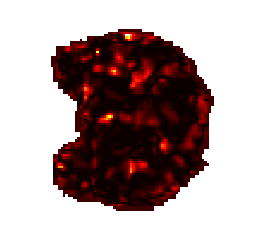

In [297]:
import matplotlib.pyplot as plt
%matplotlib inline

scores_3d = scores.reshape((91, 109, 91))
plt.imshow(scores_3d[:, 75, :], origin='lower', cmap='hot')
plt.axis('off')
plt.show()

Then, after fitting the transformer, we can call the `transform(X)` method that will actually select the subset according to the selector:

In [300]:
print("Shape of mvp.X before transform: %r ..." % (mvp.X.shape,))
X_after_ufs = select100best.transform(mvp.X)

print("... and shape of mvp.X after transform: %r." % (X_after_ufs.shape,))

Shape of mvp.X before transform: (10, 902629) ...
... and shape of mvp.X after transform: (10, 100).


As you can see, the transformer correctly selected a subset of 100 voxels from our mvp.X matrix! Now, both selectors were fit on the entire dataset, which is often course not how it should be done: because they use information from the labels (`y`), this step should be cross-validated. 

<div class='alert alert-danger'>
**Assignment 2** (2 points): 
</div>

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
folds = skf.split(mvp.X, mvp.y)

accuracy = []

select50best = SelectKBest(score_func=f_classif, k=50)

for fold in folds:
    
    train_idx, test_idx = fold
    
    # ToDo: make X_train, X_test, y_train, y_test
    
    # ToDo: call the select50best fit method (on train) and predict (on test)
    
    # ToDo: calculate accuracy

# ToDo: calculate average accuracy


## 5. Permutation testing

## 6. Feature visualization